# Analyse de la maintenance prédictive

Méthodologie:

- Construire des features par cycle

- Comparer plusieurs modèles sur les 2000 premiers cycles

- Utiliser une validation croisée

- Sélectionner le meilleur modèle

- Évaluer sa performance finale sur les 205 cycles restants (jeu de test final, jamais vu)

👉 un train / validation / test propre

# Préparation des données

Charger les données

In [1]:
import os
import pandas as pd

# Chemins des fichiers
ps2_path = "../data/PS2.txt"
fs1_path = "../data/FS1.txt"
profile_path = "../data/profile.txt"

# Vérifier existence
for path in [ps2_path, fs1_path, profile_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable : {path}")

# Charger les fichiers capteurs
ps2 = pd.read_csv(ps2_path, sep="\t", header=None)
fs1 = pd.read_csv(fs1_path, sep="\t", header=None)

# Charger le fichier profile
profile = pd.read_csv(profile_path, sep="\t", header=None)
profile.columns = ["cooler_condition", "valve_condition", "pump_leakage", "accumulator_pressure", "stable_flag"]


Création de la variable cible (binaire)

In [2]:
# 1100% = optimal (0) vs Non optimal (1)
y = (profile["valve_condition"] != 100).astype(int)

In [3]:
y.value_counts()

valve_condition
0    1125
1    1080
Name: count, dtype: int64

Feature engineering

In [4]:
import numpy as np

def extract_features(df, df_name):
    return pd.DataFrame({
        f"{df_name}_mean": df.mean(axis=1),
        f"{df_name}_std": df.std(axis=1),
        f"{df_name}_min": df.min(axis=1),
        f"{df_name}_max": df.max(axis=1)
    })

X_ps2 = extract_features(ps2, "ps2")
X_fs1 = extract_features(fs1, "fs1")

XX = pd.concat([X_ps2, X_fs1], axis=1)


In [5]:
XX.shape

(2205, 8)

In [6]:
XX.describe()

,ps2_mean,ps2_std,ps2_min,ps2_max,fs1_mean,fs1_std,fs1_min,fs1_max
count,2205.000000,2205.000000,2205.0,2205.000000,2205.000000,2205.000000,2.205000e+03,2205.000000
mean,109.379906,47.736162,0.0,166.520517,6.198549,3.040077,4.535147e-07,20.130214
std,4.986585,3.271949,0.0,0.977997,1.032883,0.189007,2.129589e-05,0.451934
min,104.406307,45.206954,0.0,155.040000,2.018572,2.665898,0.000000e+00,18.698000
25%,106.962382,46.209665,0.0,166.180000,6.391670,2.956965,0.000000e+00,19.881000
50%,107.730169,46.805986,0.0,166.650000,6.576673,2.984821,0.000000e+00,20.363000
75%,109.421612,47.207567,0.0,167.100000,6.657508,3.020458,0.000000e+00,20.479000
max,131.589089,59.553248,0.0,167.770000,6.722707,3.742224,1.000000e-03,20.479000


Suppression des minimaux (trop proche de zéo)

In [7]:
X = XX.drop(columns=[ "ps2_min","fs1_min"])

In [8]:
X.shape

(2205, 6)

# Diviser le jeu de données en train / test final

In [9]:
# les 2000 premiers cycles
X_train = X.iloc[:2000] 
y_train = y.iloc[:2000]

# les 205 derniers cycles
X_test = X.iloc[2000:] 
y_test = y.iloc[2000:]

In [10]:
# Verification des dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2000, 6), (2000,), (205, 6), (205,))

# Pipelines + modèles

Load packages

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Modèles comparés

In [12]:
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

XGBoost

In [13]:
from xgboost import XGBClassifier

models["XGBoost"] = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)


# Validation croisée sur les 2000 cycles

In [15]:
from sklearn.model_selection import cross_validate

results = {}

for name, model in models.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=["accuracy", "f1", "recall", "precision"]
    )
    results[name] = {
        "accuracy": scores["test_accuracy"].mean(),
        "f1-score": scores["test_f1"].mean(),
        "recall": scores["test_recall"].mean(),
        "precision": scores["test_precision"].mean()
    }

pd.DataFrame(results).T


,accuracy,f1-score,recall,precision
LogisticRegression,0.8260,0.784559,0.707018,0.944937
DecisionTree,0.7925,0.790623,0.807034,0.818637
RandomForest,0.8185,0.828417,0.882762,0.821531
XGBoost,0.8285,0.836183,0.860757,0.845224


# Sélection du meilleur modèle

In [16]:
best_model_name = "XGBoost"
best_model = models[best_model_name]


Quel est le meilleur modèle ?

XGBoost est le meilleur modèle globalement.

Rappel de l'objectif métier :

Détecter les cycles NON optimaux (classe 1)

→ minimiser les défauts non détectés (FN)

→ maximiser le recall, tout en gardant un bon équilibre global.

- Le F1-score est la métrique de choix
- XGBoost est le meilleur compromis.

# Entraînement final sur les 2000 cycles

In [21]:
best_model.fit(X_train, y_train)

# Sauvegarde du modèle (en amont)
import joblib

joblib.dump(best_model, "../src/best_model.pkl")


['../src/best_model.pkl']

# Évaluation finale sur les 205 cycles

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 73   0]
 [ 27 105]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        73
           1       1.00      0.80      0.89       132

    accuracy                           0.87       205
   macro avg       0.86      0.90      0.87       205
weighted avg       0.90      0.87      0.87       205



| Réel \ Prédit       | Optimal (0) | Non optimal (1) |
| ------------------- | ----------- | --------------- |
| **Optimal (0)**     | 73 ✅       | 0 ❌           |
| **Non optimal (1)** | 27 ⚠️       | 105 ✅         |


Interprétation métier

Cycles optimaux (classe 0)

- 73 cycles optimaux correctement détectés

- 0 fausse alerte

👉 Le modèle ne déclenche jamais d’alerte inutile sur un cycle sain


⚠️ Cycles non optimaux (classe 1)

- 105 défauts correctement détectés

- 27 défauts ratés (FN)

👉 Environ 20 % des défauts ne sont pas détectés

🔹 Classe 1 = NON optimal (prioritaire)

- Recall = 0.80

👉 Le modèle détecte 80 % des cycles non optimaux

👉 20 % échappent à la détection (risque métier)

- Precision = 1.00

👉 Chaque alerte correspond à un vrai problème

👉 Aucune fausse alerte

- F1-score = 0.89

👉 Très bon compromis détection / fiabilité

🔹 Classe 0 = optimal

- Recall = 1.00

👉 Aucun cycle sain n’est mal classé

🔹 Accuracy globale = 0.87

- 87 % des cycles correctement classés

- Bon score, mais l’accuracy seule n’est pas suffisante en maintenance prédictive

# Importance des variables

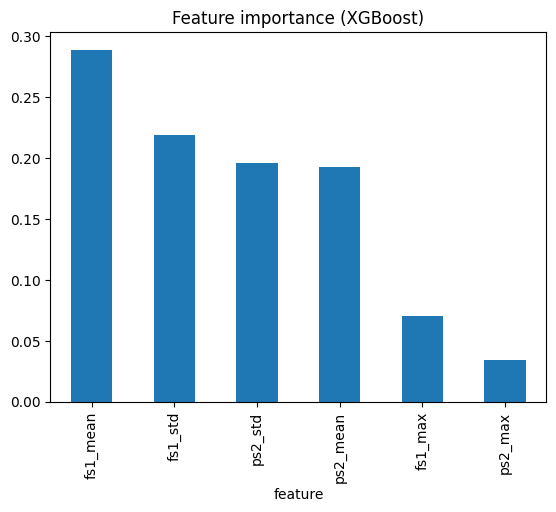

In [19]:

import pandas as pd
import matplotlib.pyplot as plt

importances = best_model.feature_importances_

features = X_train.columns

df_imp = (
    pd.DataFrame({
        "feature": features,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

df_imp.plot(
    x="feature",
    y="importance",
    kind="bar",
    legend=False
)

plt.title("Feature importance (XGBoost)")
plt.show()


**Interprétation du résultat**

👉 fs1_mean et fs1_std sont les variables les plus importantes signifie que :

- Le débit volumique (FS1) est le signal le plus discriminant pour prédire l’état de la valve

- Les variations de débit (instabilité, dispersion) sont fortement corrélées à une dégradation de la valve

- Une valve défectueuse impacte directement :

   - le niveau moyen de débit

   - la variabilité du débit pendant le cycle

➡️ Résultat très cohérent physiquement

🧠 Lecture métier (clé pour soutenance)

Une dégradation de la valve entraîne une perte de contrôle du débit hydraulique, se traduisant par des variations accrues et une diminution du débit moyen. Ces phénomènes sont capturés par les statistiques fs1_mean et fs1_std, qui apparaissent comme les variables les plus contributives dans le modèle.

Les modèles ont été comparés à l’aide d’une validation croisée à 5 plis sur les 2000 premiers cycles.
Le modèle présentant les meilleures performances moyennes (F1-score) a été sélectionné.
Ce modèle a ensuite été entraîné sur l’ensemble des 2000 cycles, puis évalué sur les 205 cycles restants, constituant un jeu de test indépendant.



L’objectif étant de prédire la condition de la valve à partir de signaux capteurs, seules les variables directement mesurées pendant le cycle ont été utilisées comme variables explicatives.
Les variables de diagnostic (conditions des composants) ont été exclues afin d’éviter toute fuite d’information et garantir une évaluation réaliste des performances du modèle.

Les métriques deviennent naturelles

Avec :

1 = NON optimal


Recall = capacité à détecter les défauts

False Negative = défaut raté (grave ❌)

False Positive = fausse alerte (moins grave)

predictive_maintenance_api/
│
├── app/
│   ├── main.py              # API FastAPI
│   ├── model.py             # Chargement du modèle
│   └── schemas.py           # Schémas Pydantic
│
├── best_model.pkl           # Modèle entraîné (XGBoost)
├── requirements.txt
├── Dockerfile
└── README.md


In [ ]:
# Sauvegarde du modèle (en amont)
import joblib

joblib.dump(best_model, "best_model.pkl")


In [ ]:
# Schéma des données (schemas.py)
from pydantic import BaseModel

class CycleInput(BaseModel):
    ps2_mean: float
    ps2_std: float
    ps2_min: float
    ps2_max: float
    fs1_mean: float
    fs1_std: float
    fs1_min: float
    fs1_max: float


In [ ]:
# Chargement du modèle (model.py)
import joblib

MODEL_PATH = "best_model.pkl"

def load_model():
    return joblib.load(MODEL_PATH)


In [ ]:
# API FastAPI (main.py)
from fastapi import FastAPI
import pandas as pd

from app.schemas import CycleInput
from app.model import load_model

app = FastAPI(
    title="Predictive Maintenance API",
    description="Prédiction de la condition de la valve",
    version="1.0"
)

model = load_model()

@app.get("/")
def health_check():
    return {"status": "API is running"}

@app.post("/predict")
def predict(cycle: CycleInput):
    X = pd.DataFrame([cycle.dict()])

    proba = model.predict_proba(X)[0][1]
    prediction = int(proba >= 0.5)

    return {
        "prediction": prediction,
        "label": "NON_OPTIMAL" if prediction == 1 else "OPTIMAL",
        "failure_probability": round(proba, 3)
    }
# Docker file
FROM python:3.10-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY app/ app/
COPY best_model.pkl .

EXPOSE 8000

CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8000"]




Le modèle retenu (XGBoost) est déployé via une API FastAPI encapsulée dans un conteneur Docker. L’API permet de prédire la probabilité de dégradation de la valve à partir des signaux capteurs d’un cycle, facilitant son intégration dans un système industriel.